In [34]:
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
interactions = pd.read_csv("data/interactions.csv")
targets = pd.read_csv("submit/targets.csv")
users = pd.read_csv("data/users.csv")
candidates = pd.read_csv("submit/candidates.csv")

In [72]:
candidates.groupby("user_id").size()

user_id
560         200
3410        200
5620        200
5700        200
6120        200
           ... 
11943310    200
11943520    200
11946520    200
11951140    200
11951620    200
Length: 5067, dtype: int64

In [48]:
display(interactions.head())
display(targets.head())
display(users.head())
display(candidates.head())

,user_id,edition_id,event_type,rating,event_ts
0,560,1012411658,2,6.0,2024-12-24 19:02:14
1,560,1008465904,2,6.0,2025-01-10 19:18:04
2,560,1001243738,2,10.0,2025-01-25 11:28:11
3,560,1009492501,2,8.0,2025-01-25 11:28:42
4,560,1000118974,2,8.0,2025-03-10 18:14:17


,user_id
0,1310260
1,4720390
2,5718550
3,1707730
4,11053490


,user_id,gender,age
0,560,2.0,9.0
1,3410,2.0,39.0
2,5620,1.0,42.0
3,5700,2.0,40.0
4,6120,2.0,32.0


,user_id,edition_id
0,1310260,1002730309
1,1310260,1008890482
2,1310260,1009588990
3,1310260,1002062846
4,1310260,1009877656


In [16]:
targets.shape

(5067, 1)

In [5]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231210 entries, 0 to 231209
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     231210 non-null  int64  
 1   edition_id  231210 non-null  int64  
 2   event_type  231210 non-null  int64  
 3   rating      125369 non-null  float64
 4   event_ts    231210 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 8.8+ MB


In [30]:
interactions.groupby("user_id")["event_type"].sum().sort_values(ascending=False)

user_id
11053490    566
4346950     527
8694820     520
11275490    498
11596540    498
           ... 
11527840      6
680200        5
1336510       5
199320        5
11423900      5
Name: event_type, Length: 5067, dtype: int64

rows: 231210
parsed_ok: 231210
parsed_na: 0
min: 2024-10-14 18:48:56
max: 2025-04-12 12:44:23


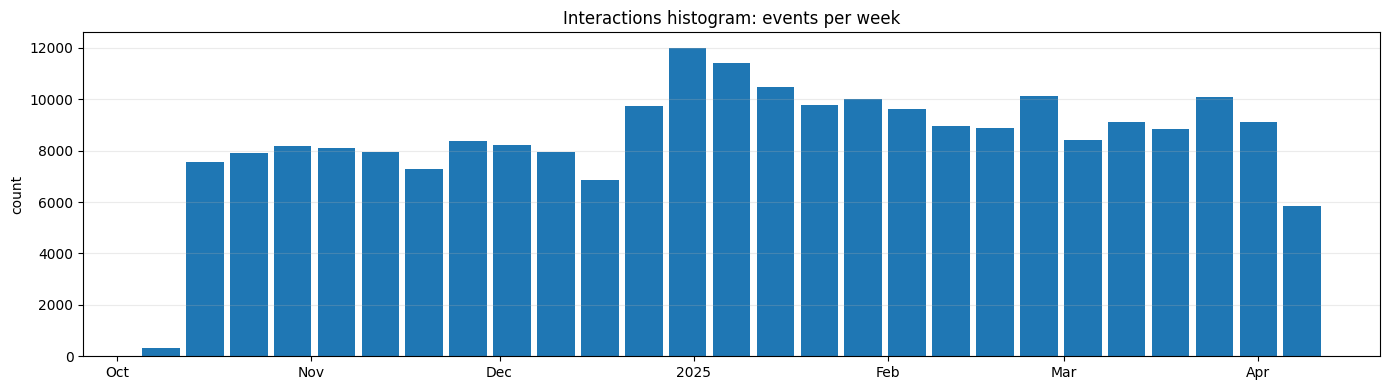

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) parse datetime
ts = pd.to_datetime(interactions["event_ts"], errors="coerce")

# 2) sanity-check + min/max
print("rows:", len(ts))
print("parsed_ok:", ts.notna().sum())
print("parsed_na:", ts.isna().sum())
print("min:", ts.min())
print("max:", ts.max())

# 3) histogram over time: counts per week (week starts Monday)
week_start = ts.dt.to_period("W-MON").dt.start_time
counts = week_start.value_counts().sort_index()

plt.figure(figsize=(14, 4))
plt.bar(counts.index.to_pydatetime(), counts.values, width=6, align="center")
plt.title("Interactions histogram: events per week")
plt.ylabel("count")
plt.grid(True, axis="y", alpha=0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.tight_layout()
plt.show()

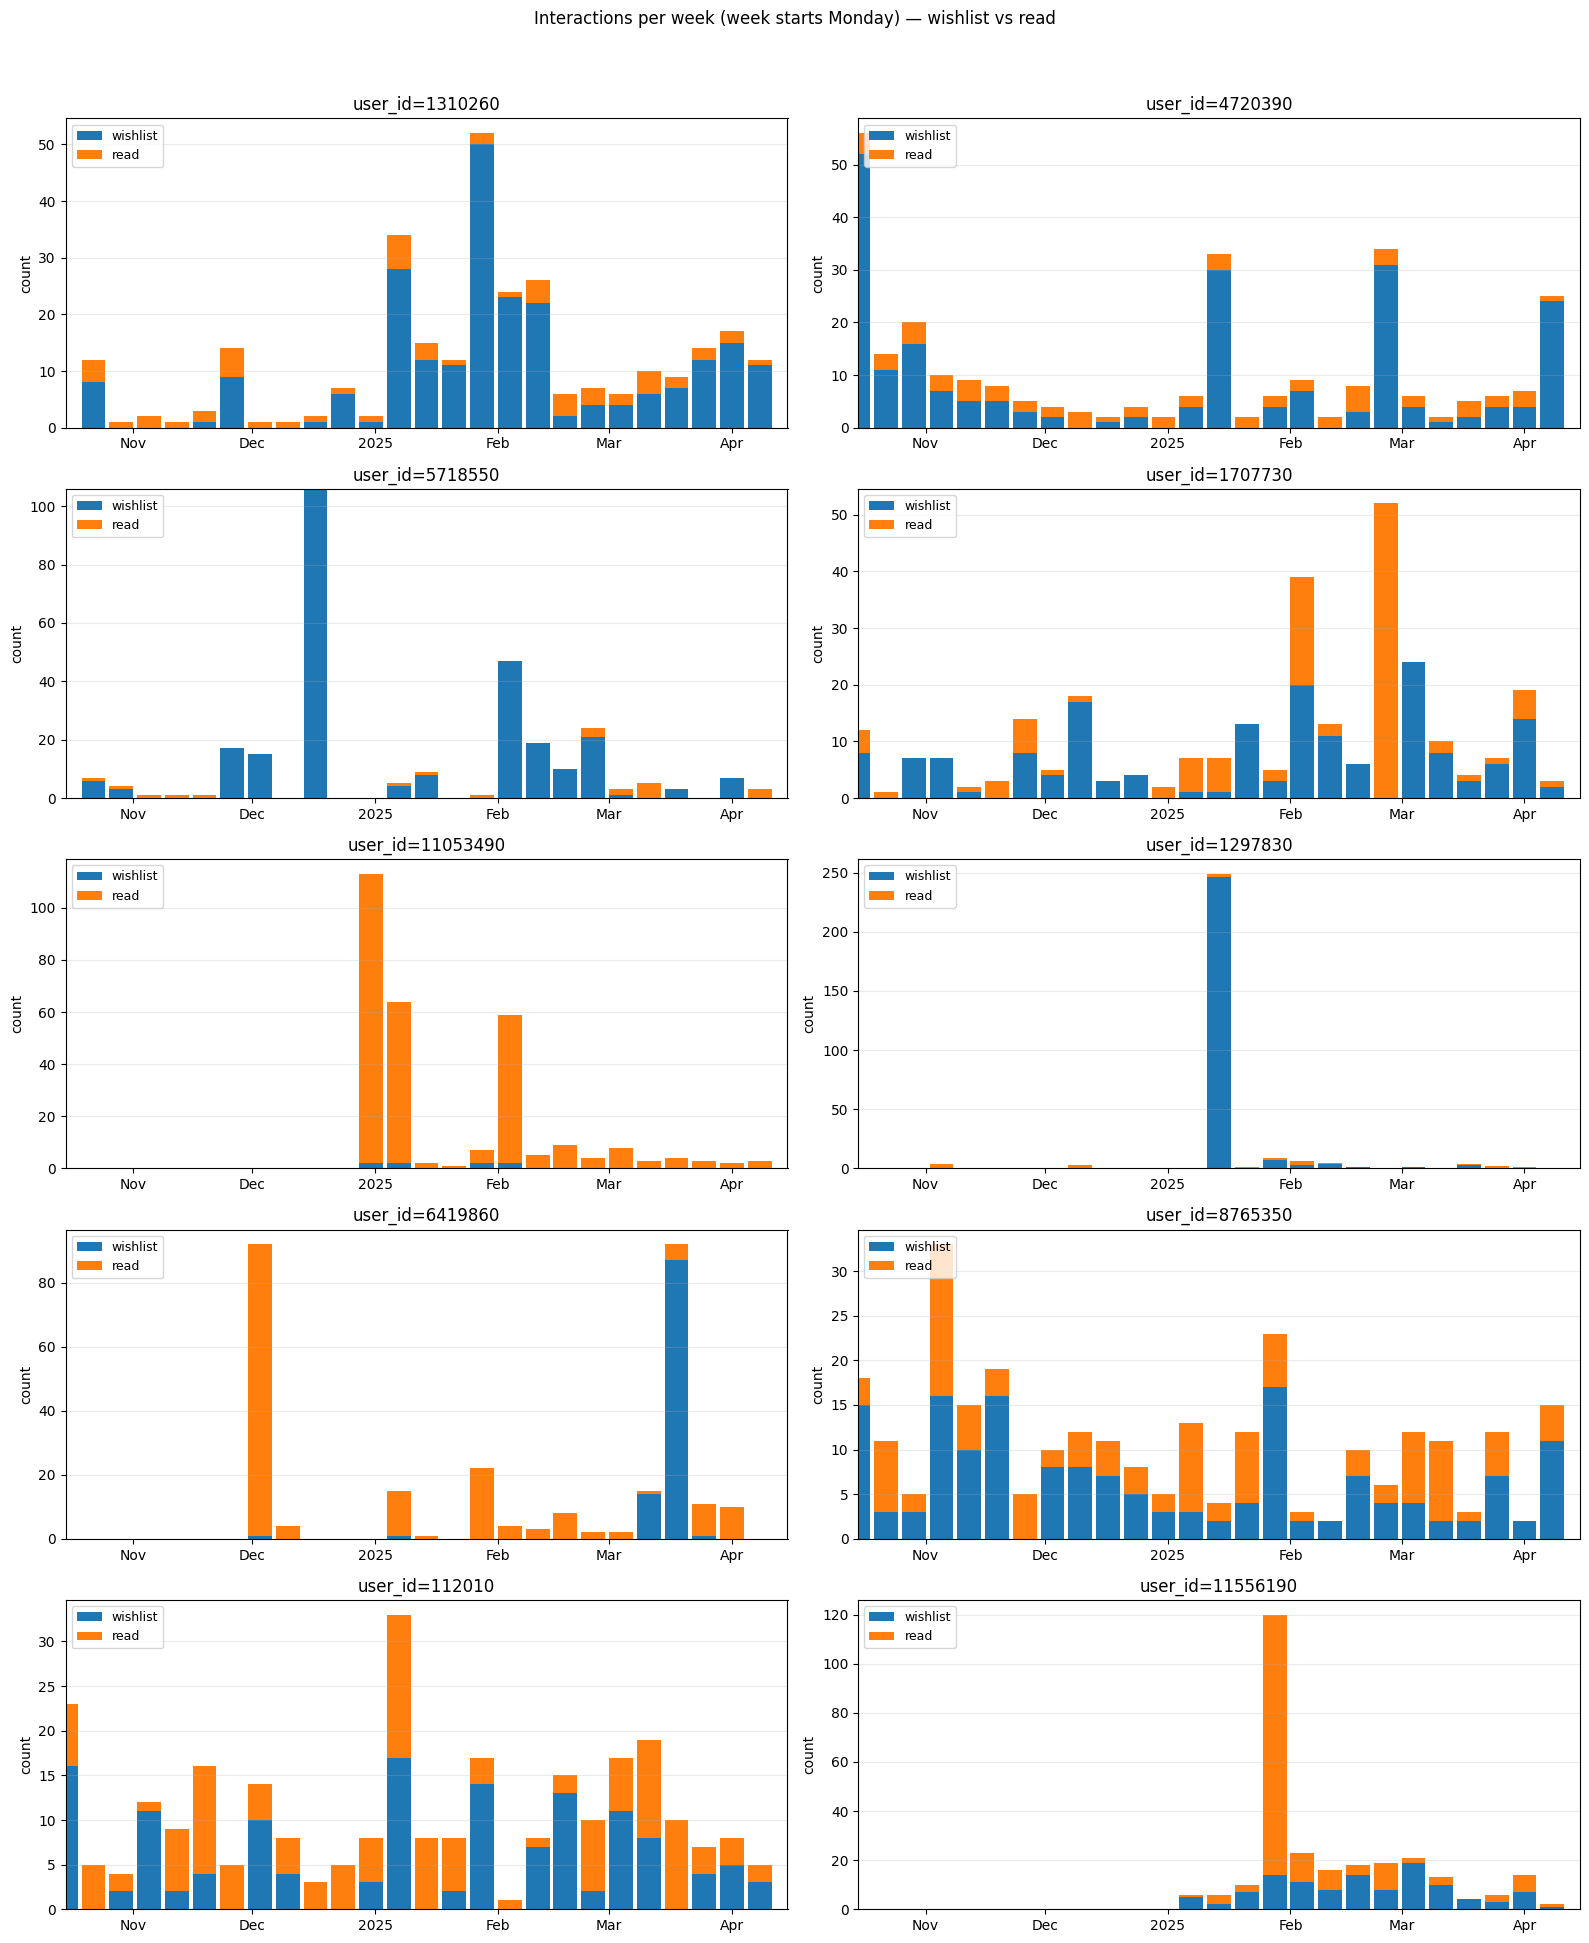

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- settings ---
EVENT_LABELS = {1: "wishlist", 2: "read"}
event_types = [1, 2]

# --- prep ---
interactions["event_ts"] = pd.to_datetime(interactions["event_ts"], errors="coerce")
df = interactions.dropna(subset=["event_ts"]).copy()

# week START (понедельник)
df["week_start"] = df["event_ts"].dt.to_period("W-MON").dt.start_time

# топ-10 активных пользователей
user_ids = df.groupby("user_id").size().sort_values(ascending=False).head(10).index.tolist()

df10 = df[df["user_id"].isin(user_ids)]
xmin = df10["week_start"].min()
xmax = df10["week_start"].max() + pd.Timedelta(days=7)  # чуть вправо для последней недели

# --- plot grid ---
n = len(user_ids)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3.8 * nrows), sharex=False)
axes = np.array(axes).reshape(-1)

for i, uid in enumerate(user_ids):
    ax = axes[i]
    u = df10[df10["user_id"] == uid]

    counts = (
        u.groupby(["week_start", "event_type"])
         .size()
         .unstack(fill_value=0)
         .reindex(columns=event_types, fill_value=0)
         .sort_index()
    )

    x = counts.index.to_pydatetime()
    bottom = np.zeros(len(counts), dtype=float)

    for et in event_types:
        vals = counts[et].to_numpy()
        ax.bar(x, vals, bottom=bottom, width=6, align="center",
               label=EVENT_LABELS.get(et, str(et)))
        bottom += vals

    ax.set_title(f"user_id={uid}")
    ax.set_ylabel("count")
    ax.set_xlim(xmin, xmax)

    # timeline on EVERY subplot
    ax.tick_params(axis="x", labelbottom=True)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    ax.grid(True, axis="y", alpha=0.25)
    ax.legend(loc="upper left", fontsize=9)

# выключаем лишние оси
for j in range(n, len(axes)):
    axes[j].axis("off")

fig.suptitle("Interactions per week (week starts Monday) — wishlist vs read", y=1.02)
fig.tight_layout()
plt.show()

In [49]:
import pandas as pd
import numpy as np

# загрузка
editions     = pd.read_csv("data/editions.csv")
authors      = pd.read_csv("data/authors.csv")
genres       = pd.read_csv("data/genres.csv")
book_genres  = pd.read_csv("data/book_genres.csv")

# event_ts в datetime (чтобы потом удобно было анализировать)
interactions["event_ts"] = pd.to_datetime(interactions["event_ts"], errors="coerce")

def pick_col(df, candidates):
    """Вернуть первый существующий столбец из списка кандидатов."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# ---- 1) interactions -> editions ----
ed_key = pick_col(interactions, ["edition_id"])
assert ed_key is not None, "Не нашёл edition_id в interactions"

df = interactions.merge(
    editions,
    left_on=ed_key,
    right_on=pick_col(editions, ["edition_id"]),
    how="left",
    suffixes=("", "_ed"),
)

# ---- 2) editions -> authors ----
# ищем author_id в editions и authors
ed_author_key = pick_col(editions, ["author_id", "author", "authors_id"])
au_key        = pick_col(authors,  ["author_id", "id"])

if ed_author_key and au_key:
    df = df.merge(
        authors,
        left_on=ed_author_key,
        right_on=au_key,
        how="left",
        suffixes=("", "_author"),
    )
else:
    print("⚠️ Не смог смержить authors: не нашёл подходящие ключи (author_id/id).")

# ---- 3) editions/interactions -> genres через book_genres ----
# типично: book_genres имеет edition_id или book_id. Поддержим оба случая.
bg_ed_key   = pick_col(book_genres, ["edition_id"])
bg_book_key = pick_col(book_genres, ["book_id"])
ed_book_key = pick_col(editions, ["book_id"])

genre_key_bg = pick_col(book_genres, ["genre_id"])
genre_key_g  = pick_col(genres, ["genre_id", "id"])

assert genre_key_bg is not None, "Не нашёл genre_id в book_genres"
assert genre_key_g  is not None, "Не нашёл genre_id/id в genres"

if bg_ed_key:
    join_key_df = pick_col(editions, ["edition_id"])
    join_key_bg = bg_ed_key
elif (bg_book_key is not None) and (ed_book_key is not None):
    join_key_df = ed_book_key
    join_key_bg = bg_book_key
else:
    raise ValueError("Не могу понять, как связать book_genres с editions (нет edition_id и нет пары book_id).")

# ---------- ВАРИАНТ A: LONG (interaction × genre) ----------
df_long = (
    df.merge(book_genres, left_on=join_key_df, right_on=join_key_bg, how="left")
      .merge(genres, left_on=genre_key_bg, right_on=genre_key_g, how="left", suffixes=("", "_genre"))
)

# ---------- ВАРИАНТ B: WIDE/AGG (genres списком/строкой на 1 interaction) ----------
# собираем жанры по ключу (edition_id или book_id), потом мержим обратно в df
genre_name_col = pick_col(genres, ["genre_name", "name", "title"])
if genre_name_col is None:
    # если вдруг жанр называется иначе — можно посмотреть genres.columns
    genre_name_col = genres.columns[1]  # fallback

genres_per_item = (
    book_genres.merge(genres, left_on=genre_key_bg, right_on=genre_key_g, how="left")
              .groupby(join_key_bg)[genre_name_col]
              .apply(lambda s: sorted(set(s.dropna().astype(str))))
              .reset_index()
              .rename(columns={genre_name_col: "genres_list"})
)

df_wide = df.merge(genres_per_item, left_on=join_key_df, right_on=join_key_bg, how="left")
df_wide["genres"] = df_wide["genres_list"].apply(lambda x: ", ".join(x) if isinstance(x, list) else np.nan)

print("df_long shape:", df_long.shape, "| df_wide shape:", df_wide.shape)
display(df_wide.head())


df_long shape: (464744, 16) | df_wide shape: (231210, 16)


,user_id,edition_id,event_type,rating,event_ts,book_id,author_id,publication_year,age_restriction,language_id,publisher_id,title,description,author_name,genres_list,genres
0,560,1012411658,2,6.0,2024-12-24 19:02:14,8387168,1085990.0,2024,16,119,123745,И время остановилось,"Во французском Берри, краю замков и зеленых по...",Кларисса Сабар,[Современная-зарубежная-литература],Современная-зарубежная-литература
1,560,1008465904,2,6.0,2025-01-10 19:18:04,6064826,2338126.0,2023,16,119,1470,Смерть и круассаны,"Ричард Эйнсворт — хозяин небольшой гостиницы, ...",Йен Мур,"[Зарубежные-детективы, Иронические-детективы, ...","Зарубежные-детективы, Иронические-детективы, Ю..."
2,560,1001243738,2,10.0,2025-01-25 11:28:11,1047228,11528.0,1984,16,119,1016,Evgenia Ivanovna,"Повесть Леонида Леонова, одного из крупнейших ...",Леонид Леонов,[Классическая-проза],Классическая-проза
3,560,1009492501,2,8.0,2025-01-25 11:28:42,6763729,2355.0,0,18,119,7,Transhumanism inc. + KGBT+,В комплект вошли два известных романа Виктора ...,Виктор Пелевин,[unknown],unknown
4,560,1000118974,2,8.0,2025-03-10 18:14:17,127995,123194.0,2005,18,119,33,Тьма на ладони,"...Рекламный ролик, снятый 20 лет назад, в одн...",Иори Фудзивара,"[Зарубежные-детективы, Современная-зарубежная-...","Зарубежные-детективы, Современная-зарубежная-л..."


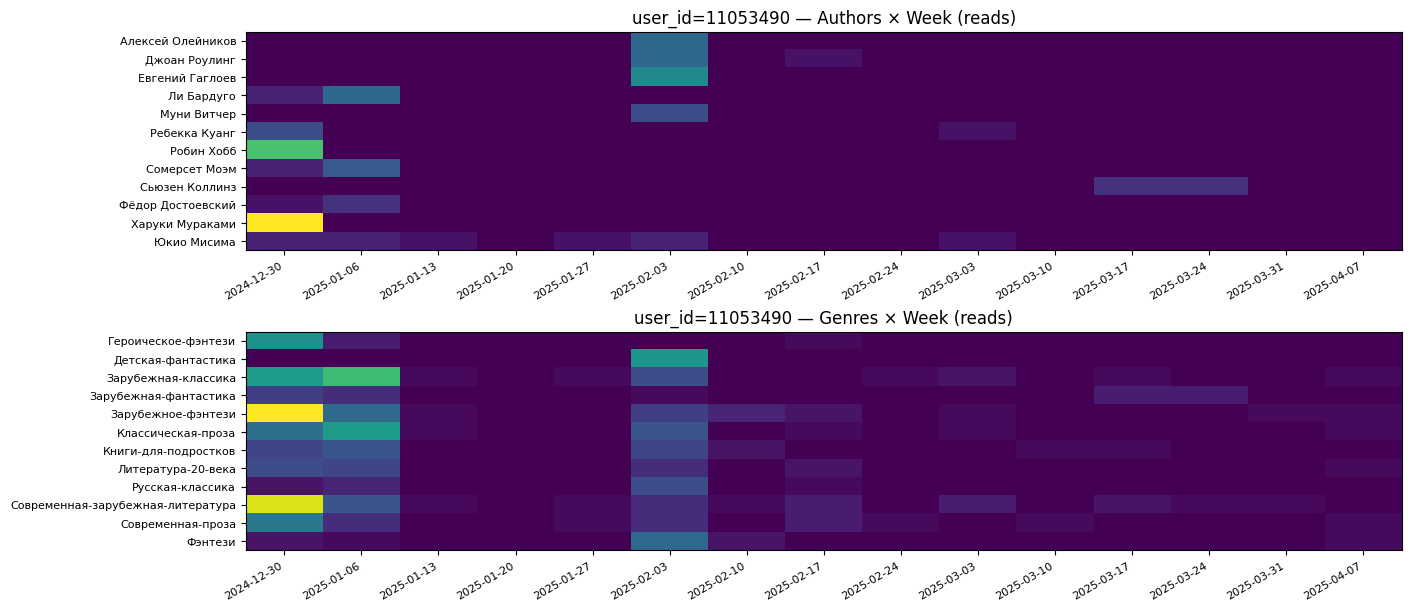

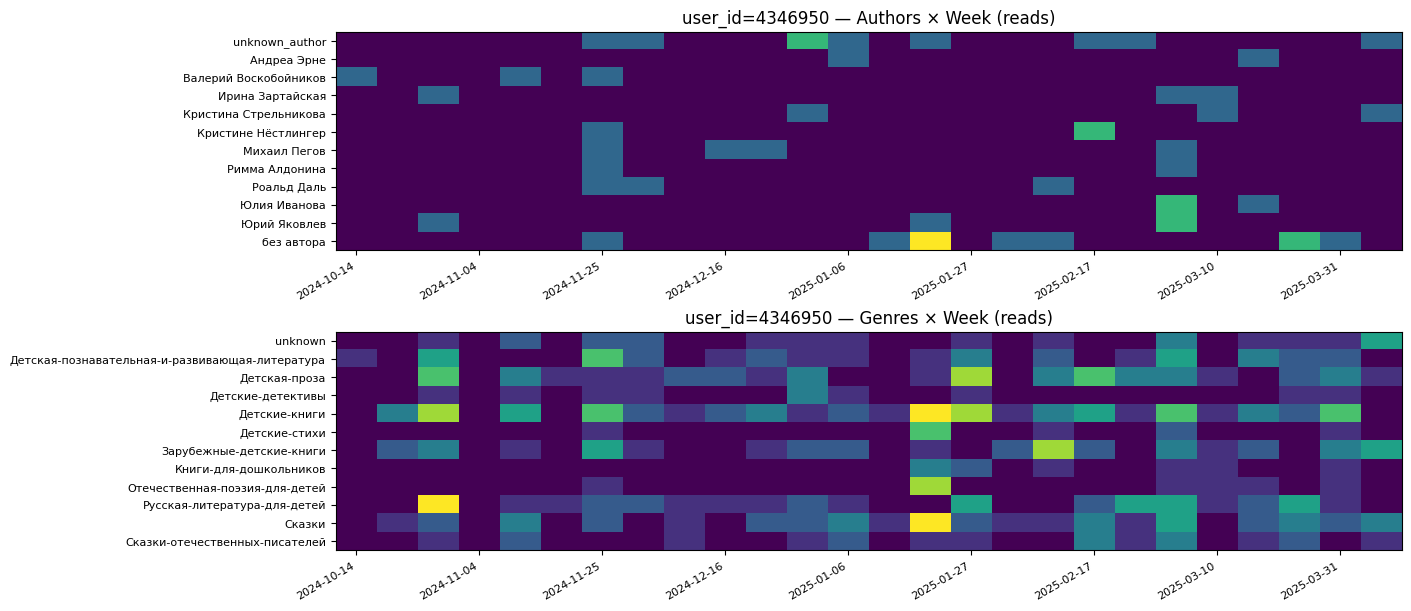

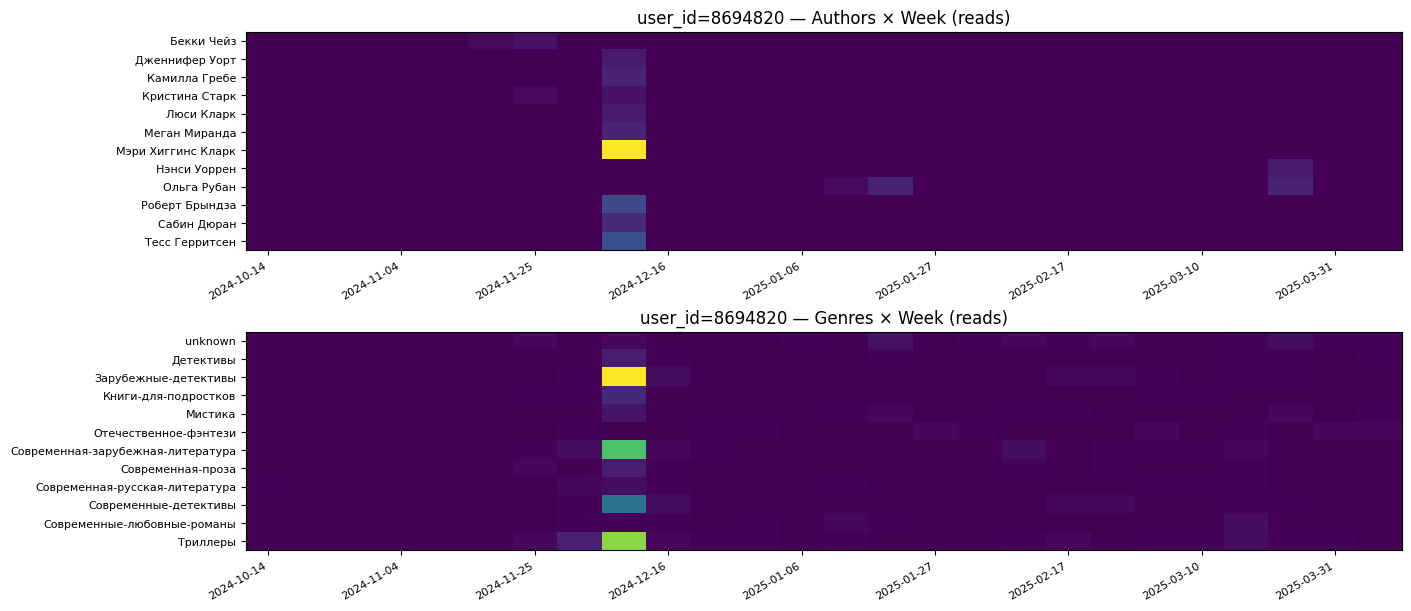

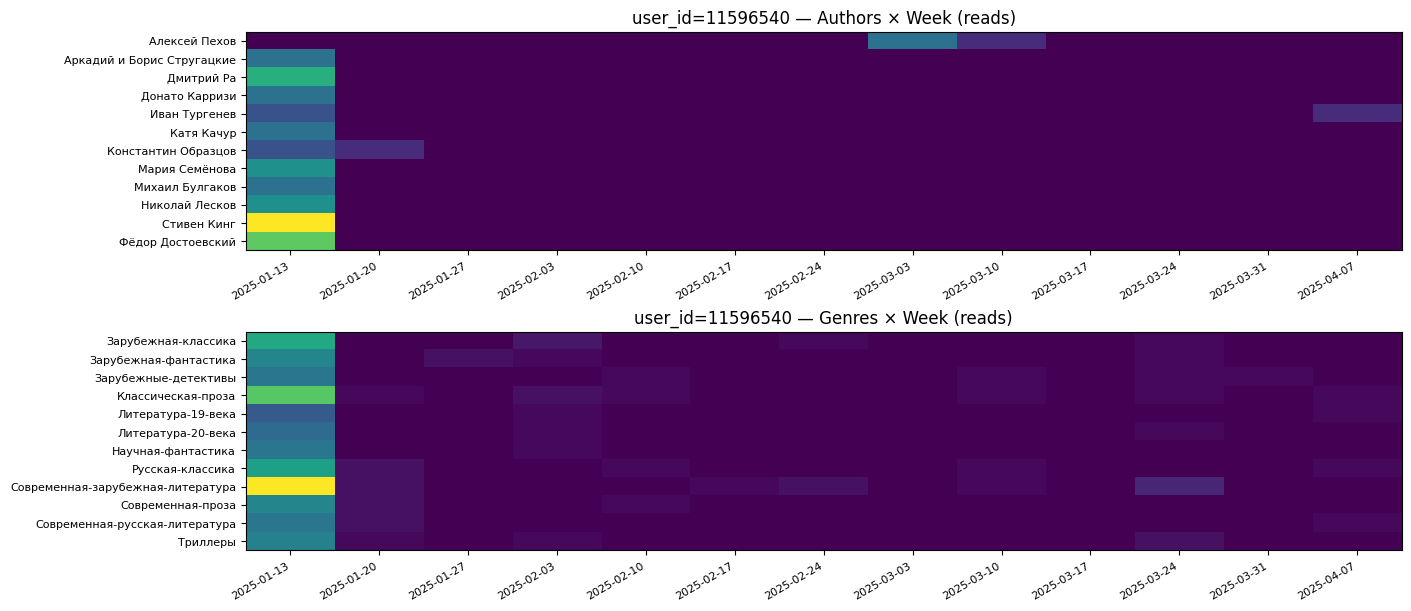

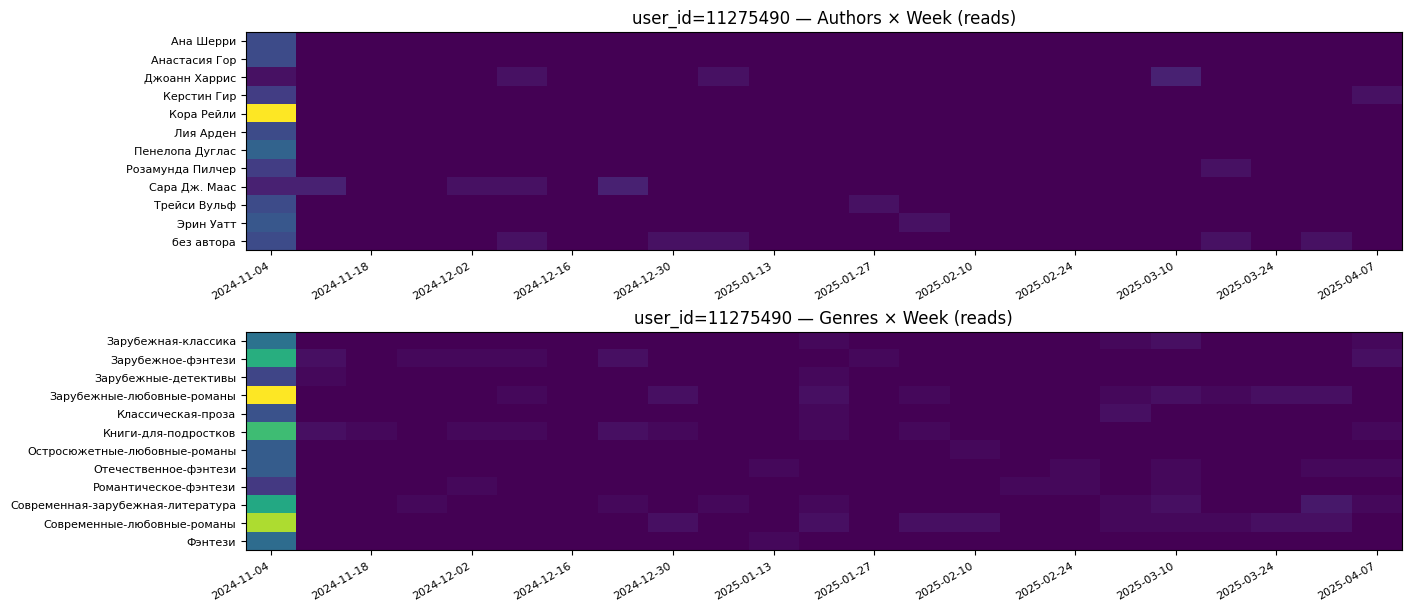

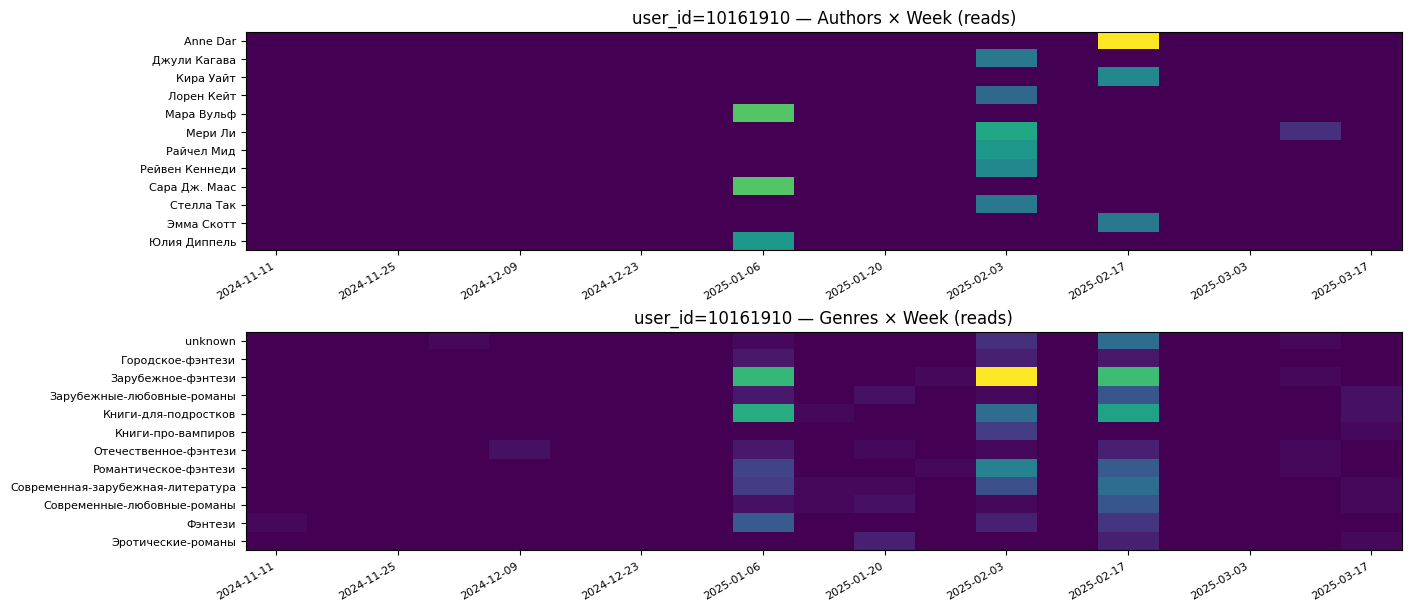

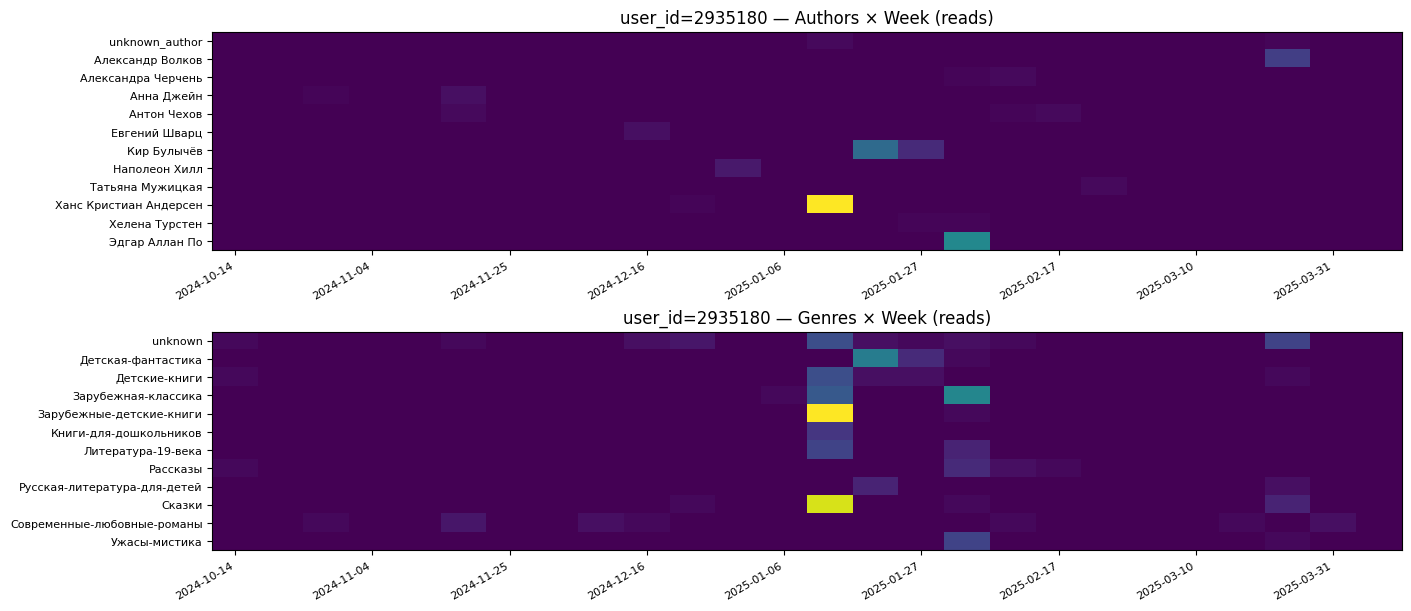

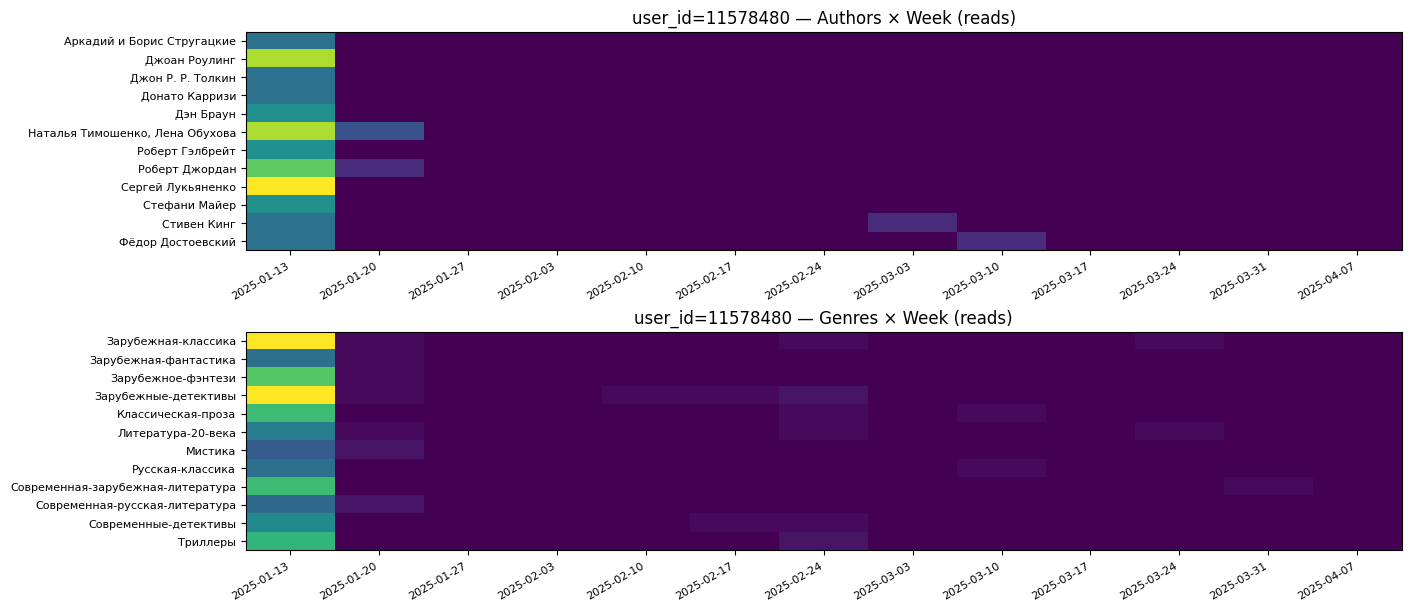

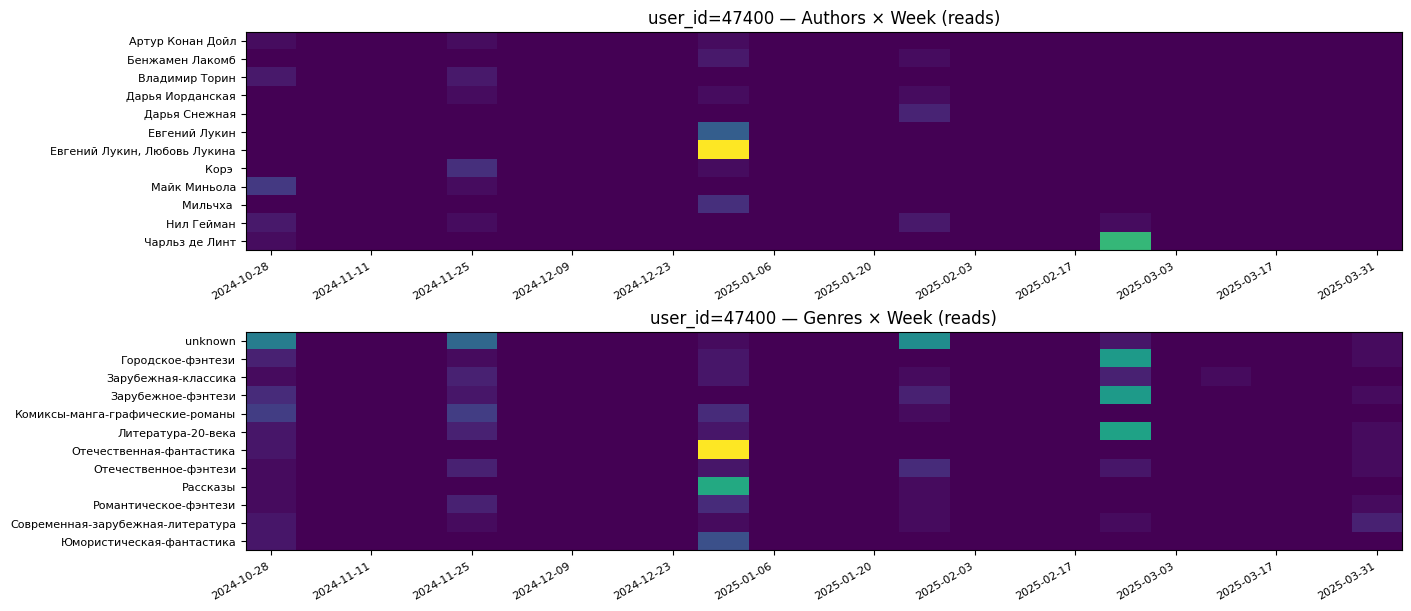

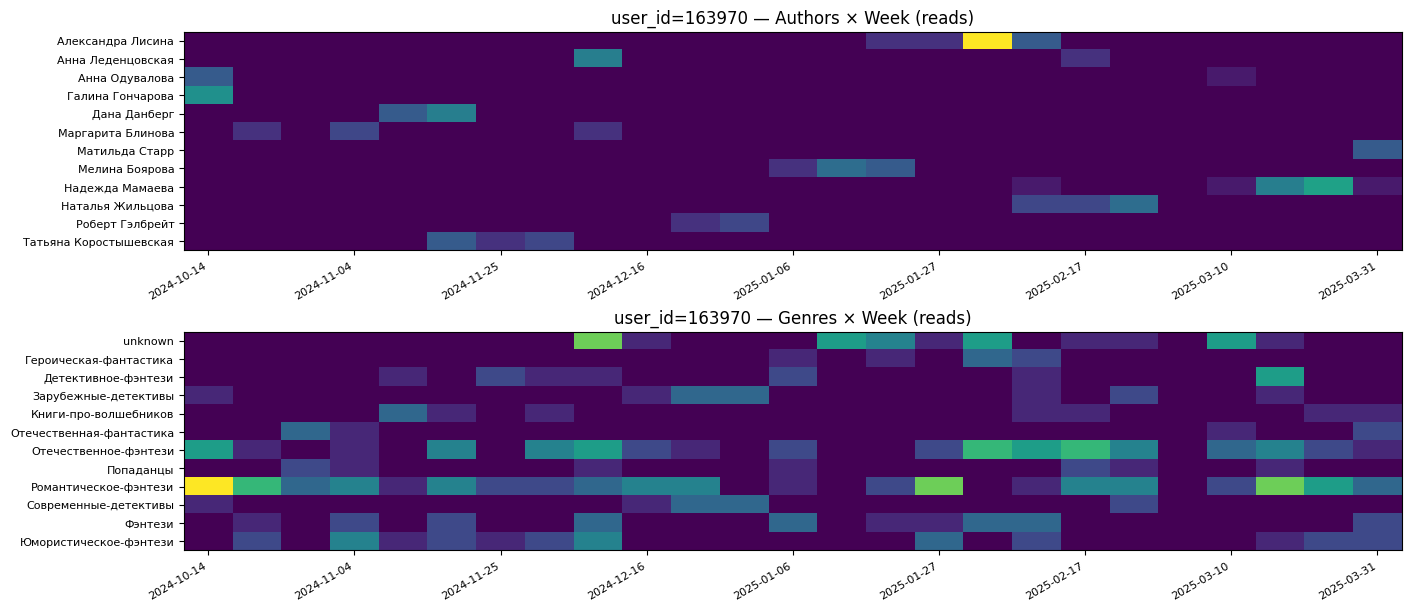

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TOP_K_AUTHORS = 12
TOP_K_GENRES  = 12

df = df_wide.copy()
df["event_ts"] = pd.to_datetime(df["event_ts"], errors="coerce")
df = df.dropna(subset=["event_ts"])

# only reads
df = df[df["event_type"] == 2].copy()

# week_start = понедельник 00:00
df["week_start"] = (df["event_ts"] - pd.to_timedelta(df["event_ts"].dt.weekday, unit="D")).dt.floor("D")

# топ-10 по reads
user_ids = df["user_id"].value_counts().head(10).index.tolist()

def plot_heatmap(ax, pivot, title):
    if pivot.empty or pivot.to_numpy().sum() == 0:
        ax.set_title(title + " (empty)")
        ax.axis("off")
        return
    mat = pivot.T.values
    ax.imshow(mat, aspect="auto", interpolation="nearest")
    ax.set_yticks(np.arange(len(pivot.columns)))
    ax.set_yticklabels(pivot.columns.tolist(), fontsize=8)

    weeks = pivot.index
    step = max(1, len(weeks)//8)
    xt = np.arange(0, len(weeks), step)
    ax.set_xticks(xt)
    ax.set_xticklabels([weeks[i].strftime("%Y-%m-%d") for i in xt], rotation=30, ha="right", fontsize=8)
    ax.set_title(title)

def get_genre_list(row):
    gl = row.get("genres_list", None)
    if isinstance(gl, list):
        return gl
    g = row.get("genres", None)
    if isinstance(g, str) and g.strip():
        return [x.strip() for x in g.split(",") if x.strip()]
    return []

for uid in user_ids:
    u = df[df["user_id"] == uid].copy()
    u["author_name"] = u["author_name"].fillna("unknown_author")

    weeks_all = pd.date_range(u["week_start"].min(), u["week_start"].max(), freq="W-MON")

    # Authors
    authors_counts = u.groupby(["week_start", "author_name"]).size().reset_index(name="cnt")
    top_authors = authors_counts.groupby("author_name")["cnt"].sum().sort_values(ascending=False).head(TOP_K_AUTHORS).index
    authors_counts = authors_counts[authors_counts["author_name"].isin(top_authors)]

    pivot_auth = (authors_counts.pivot_table(index="week_start", columns="author_name", values="cnt",
                                            aggfunc="sum", fill_value=0)
                              .reindex(weeks_all, fill_value=0))

    # Genres
    u["genres_list2"] = u.apply(get_genre_list, axis=1)
    g = u[["week_start","genres_list2"]].explode("genres_list2").rename(columns={"genres_list2":"genre"})
    g = g.dropna(subset=["genre"])
    g["genre"] = g["genre"].astype(str)

    genres_counts = g.groupby(["week_start","genre"]).size().reset_index(name="cnt")
    top_genres = genres_counts.groupby("genre")["cnt"].sum().sort_values(ascending=False).head(TOP_K_GENRES).index
    genres_counts = genres_counts[genres_counts["genre"].isin(top_genres)]

    pivot_gen = (genres_counts.pivot_table(index="week_start", columns="genre", values="cnt",
                                          aggfunc="sum", fill_value=0)
                            .reindex(weeks_all, fill_value=0))

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), constrained_layout=True)
    plot_heatmap(axes[0], pivot_auth, f"user_id={uid} — Authors × Week (reads)")
    plot_heatmap(axes[1], pivot_gen,  f"user_id={uid} — Genres × Week (reads)")
    plt.show()

In [60]:
import os, json
import pandas as pd

# --- настройки ---
OUT_DIR = "exports/users_json"
os.makedirs(OUT_DIR, exist_ok=True)

EVENT_LABELS = {1: "wishlist", 2: "read"}

# 1) выберем 10 пользователей
# Вариант A: топ-10 по числу interactions
user_ids = (
    df_wide.groupby("user_id").size().sort_values(ascending=True).head(10).index.tolist()
)

# Вариант B: первые 10 из targets (если хочешь именно их)
# user_ids = targets["user_id"].head(10).tolist()

# 2) убедимся что event_ts строка (для текстового JSON)
df = df_wide.copy()
df["event_ts"] = pd.to_datetime(df["event_ts"], errors="coerce")
df = df.dropna(subset=["event_ts"]).sort_values(["user_id", "event_ts"])
df["event_ts_str"] = df["event_ts"].dt.strftime("%Y-%m-%d %H:%M:%S")

def row_to_text(r):
    action = EVENT_LABELS.get(int(r["event_type"]), f"event_{r['event_type']}")
    title  = (r.get("title") or "").strip() if pd.notna(r.get("title")) else ""
    author = (r.get("author_name") or "").strip() if pd.notna(r.get("author_name")) else ""
    genres = (r.get("genres") or "").strip() if pd.notna(r.get("genres")) else ""
    desc   = (r.get("description") or "").strip() if pd.notna(r.get("description")) else ""

    # рейтинг только если он есть
    rating = r.get("rating")
    rating_str = ""
    if pd.notna(rating):
        # в текст, без чисел можно тоже, но обычно полезно оставить как текст
        rating_str = f" | rating: {str(float(rating)).rstrip('0').rstrip('.')}"
    
    parts = [f"{r['event_ts_str']} | {action}"]
    if title:
        parts.append(f"“{title}”")
    if author:
        parts.append(f"— {author}")
    if genres:
        parts.append(f"[{genres}]")
    if desc:
        # короткое описание, чтобы не раздувать файл
        parts.append(f"desc: {desc[:220]}{'...' if len(desc) > 220 else ''}")
    if rating_str:
        parts.append(rating_str)

    return " ".join(parts)

# 3) сохраняем по одному JSON на пользователя
manifest = []
for uid in user_ids:
    u = df[df["user_id"] == uid]

    records = [{"text": row_to_text(r)} for _, r in u.iterrows()]  # только текст
    payload = {
        "user_id": str(uid),
        "n_interactions": str(len(records)),
        "interactions": records
    }

    path = os.path.join(OUT_DIR, f"user_{uid}.json")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    manifest.append({"user_id": str(uid), "path": path, "n_interactions": str(len(records))})

print(f"Saved {len(manifest)} files into: {OUT_DIR}")
display(pd.DataFrame(manifest))

Saved 10 files into: exports/users_json


,user_id,path,n_interactions
0,6552880,exports/users_json/user_6552880.json,5
1,83510,exports/users_json/user_83510.json,5
2,11715100,exports/users_json/user_11715100.json,5
3,3191040,exports/users_json/user_3191040.json,5
4,6781180,exports/users_json/user_6781180.json,5
5,1783220,exports/users_json/user_1783220.json,5
6,134030,exports/users_json/user_134030.json,5
7,11728510,exports/users_json/user_11728510.json,5
8,9147670,exports/users_json/user_9147670.json,5
9,4470040,exports/users_json/user_4470040.json,5


In [73]:
pd.DataFrame(manifest).user_id.to_list()

['6552880',
 '83510',
 '11715100',
 '3191040',
 '6781180',
 '1783220',
 '134030',
 '11728510',
 '9147670',
 '4470040']

In [74]:
import os, json
import pandas as pd
import numpy as np

# --- какие юзеры нужны (как на скрине) ---
USER_IDS = ['6552880',
 '83510',
 '11715100',
 '3191040',
 '6781180',
 '1783220',
 '134030',
 '11728510',
 '9147670',
 '4470040']

OUT_DIR = "exports/candidates_json"
os.makedirs(OUT_DIR, exist_ok=True)

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# --- убедимся, что таблицы загружены (если у тебя они уже есть — можно не перезагружать) ---
# candidates = pd.read_csv("submit/candidates.csv")
# editions = pd.read_csv("data/editions.csv")
# authors = pd.read_csv("data/authors.csv")
# genres = pd.read_csv("data/genres.csv")
# book_genres = pd.read_csv("data/book_genres.csv")

# ============ 1) строим edition_meta: editions + authors + genres ============
ed_id = pick_col(editions, ["edition_id", "id"])
assert ed_id is not None, "Не нашёл edition_id/id в editions"

# authors join
ed_author_key = pick_col(editions, ["author_id", "authors_id", "author"])
au_key = pick_col(authors, ["author_id", "id"])
author_name_col = pick_col(authors, ["author_name", "name", "full_name", "title"])

edition_meta = editions.copy()

if ed_author_key and au_key:
    edition_meta = edition_meta.merge(
        authors,
        left_on=ed_author_key,
        right_on=au_key,
        how="left",
        suffixes=("", "_author")
    )
else:
    # если вдруг нет ключей — просто оставим без авторов
    edition_meta["author_name"] = np.nan

# стабилизируем имя автора в одном столбце author_name
if "author_name" not in edition_meta.columns:
    if author_name_col:
        edition_meta["author_name"] = edition_meta[author_name_col]
    else:
        edition_meta["author_name"] = np.nan

# genres aggregation
bg_ed_key   = pick_col(book_genres, ["edition_id"])
bg_book_key = pick_col(book_genres, ["book_id"])
ed_book_key = pick_col(editions, ["book_id"])

genre_key_bg = pick_col(book_genres, ["genre_id"])
genre_key_g  = pick_col(genres, ["genre_id", "id"])
genre_name   = pick_col(genres, ["genre_name", "name", "title"])

assert genre_key_bg is not None, "Не нашёл genre_id в book_genres"
assert genre_key_g  is not None, "Не нашёл genre_id/id в genres"
if genre_name is None:
    genre_name = genres.columns[1]  # fallback

# как связывать жанры: либо edition_id, либо book_id
if bg_ed_key:
    join_key_bg = bg_ed_key
    join_key_ed = ed_id
elif (bg_book_key is not None) and (ed_book_key is not None):
    join_key_bg = bg_book_key
    join_key_ed = ed_book_key
else:
    raise ValueError("Не могу связать book_genres с editions (нет edition_id и нет пары book_id).")

genres_per_item = (
    book_genres
    .merge(genres, left_on=genre_key_bg, right_on=genre_key_g, how="left")
    .groupby(join_key_bg)[genre_name]
    .apply(lambda s: sorted(set(s.dropna().astype(str))))
    .reset_index()
    .rename(columns={genre_name: "genres_list"})
)

edition_meta = edition_meta.merge(
    genres_per_item,
    left_on=join_key_ed,
    right_on=join_key_bg,
    how="left"
)

edition_meta["genres_list"] = edition_meta["genres_list"].apply(lambda x: x if isinstance(x, list) else [])
edition_meta["genres"] = edition_meta["genres_list"].apply(lambda xs: ", ".join(xs) if xs else "")

# оставим “человеческие” колонки + все остальное тоже можно оставить
# но для JSON лучше выбрать основные
core_cols = [
    ed_id, "title", "description", "author_name", "genres_list", "genres",
    "publication_year", "age_restriction", "language_id", "publisher_id", "book_id"
]
core_cols = [c for c in core_cols if c in edition_meta.columns]

edition_meta_small = edition_meta[core_cols].copy()

# ============ 2) merge candidates -> edition_meta ============
cand_uid = pick_col(candidates, ["user_id"])
cand_eid = pick_col(candidates, ["edition_id"])
assert cand_uid and cand_eid, "В candidates должны быть user_id и edition_id"

cand_full = candidates.merge(
    edition_meta_small,
    left_on=cand_eid,
    right_on=ed_id,
    how="left",
    suffixes=("", "_meta")
)

# ============ 3) экспорт по юзерам ============
def safe_str(x):
    if pd.isna(x):
        return ""
    return str(x)

manifest = []
for uid in USER_IDS:
    u = cand_full[cand_full[cand_uid] == uid].copy()
    u = u.drop_duplicates(subset=[cand_eid])

    # формируем список кандидатов (200 строк обычно)
    items = []
    for _, r in u.iterrows():
        items.append({
            "edition_id": int(r[cand_eid]),
            "title": safe_str(r.get("title")),
            "author_name": safe_str(r.get("author_name")),
            "genres_list": r.get("genres_list", []) if isinstance(r.get("genres_list", []), list) else [],
            "genres": safe_str(r.get("genres")),
            "description": safe_str(r.get("description")),
            # "и всё остальное" из самых полезных полей editions
            "publication_year": None if pd.isna(r.get("publication_year")) else int(r.get("publication_year")),
            "age_restriction": None if pd.isna(r.get("age_restriction")) else int(r.get("age_restriction")),
            "language_id": None if pd.isna(r.get("language_id")) else int(r.get("language_id")),
            "publisher_id": None if pd.isna(r.get("publisher_id")) else int(r.get("publisher_id")),
            "book_id": None if pd.isna(r.get("book_id")) else int(r.get("book_id")),
        })

    payload = {
        "user_id": int(uid),
        "n_candidates": len(items),
        "candidates": items
    }

    path = os.path.join(OUT_DIR, f"user_{uid}_candidates.json")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    manifest.append({"user_id": uid, "path": path, "n_candidates": len(items)})

display(pd.DataFrame(manifest))
print(f"Saved {len(manifest)} files -> {OUT_DIR}")

,user_id,path,n_candidates
0,6552880,exports/candidates_json/user_6552880_candidate...,0
1,83510,exports/candidates_json/user_83510_candidates....,0
2,11715100,exports/candidates_json/user_11715100_candidat...,0
3,3191040,exports/candidates_json/user_3191040_candidate...,0
4,6781180,exports/candidates_json/user_6781180_candidate...,0
5,1783220,exports/candidates_json/user_1783220_candidate...,0
6,134030,exports/candidates_json/user_134030_candidates...,0
7,11728510,exports/candidates_json/user_11728510_candidat...,0
8,9147670,exports/candidates_json/user_9147670_candidate...,0
9,4470040,exports/candidates_json/user_4470040_candidate...,0


Saved 10 files -> exports/candidates_json


Target users: 5067
Users with >=1 interaction: 5067
Users with 0 interactions: 0

All-events count stats:


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
n_interactions,5067.0,45.630551,46.268933,5.0,5.0,7.0,9.0,16.0,30.0,57.0,102.0,143.0,234.34,290.0


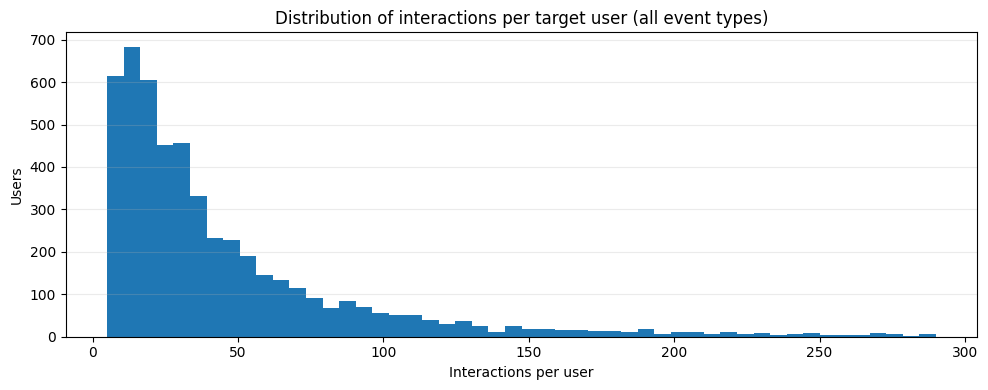

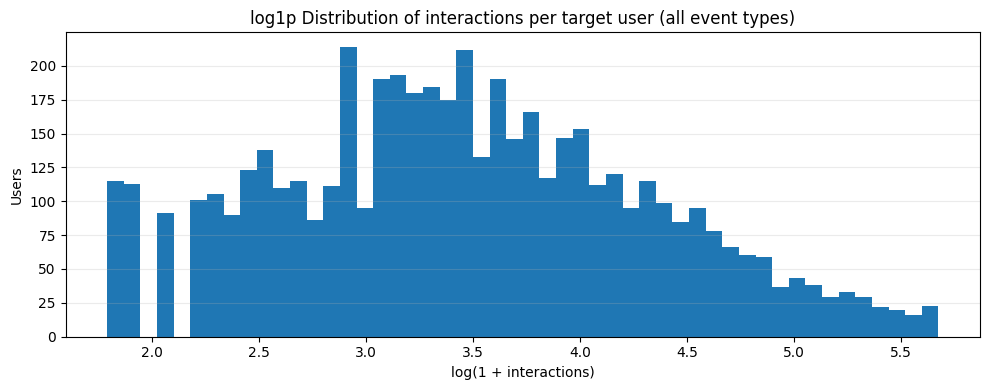


Per-type stats:


event_type,wishlist,read
count,5067.000000,5067.000000
mean,16.686600,28.943951
std,31.174801,29.297345
min,0.000000,0.000000
1%,0.000000,1.000000
5%,0.000000,4.000000
10%,0.000000,6.000000
25%,0.000000,11.000000
50%,4.000000,21.000000
75%,18.000000,35.000000


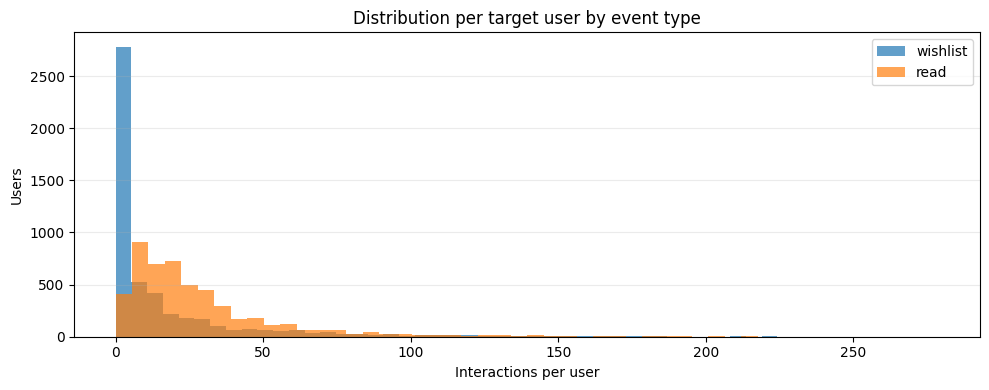

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# interactions: user_id, event_type, event_ts...
# targets: user_id

# 1) только target users
target_users = targets["user_id"].unique()
df_t = interactions[interactions["user_id"].isin(target_users)].copy()

# 2) counts per user (all events)
cnt_all = df_t.groupby("user_id").size().rename("n_interactions")

print("Target users:", len(target_users))
print("Users with >=1 interaction:", cnt_all.shape[0])
print("Users with 0 interactions:", len(target_users) - cnt_all.shape[0])
print("\nAll-events count stats:")
display(cnt_all.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).to_frame().T)

# 3) гистограмма (лог-шкала по X удобнее, потому что хвост обычно длинный)
plt.figure(figsize=(10,4))
plt.hist(cnt_all.values, bins=50)
plt.title("Distribution of interactions per target user (all event types)")
plt.xlabel("Interactions per user")
plt.ylabel("Users")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(np.log1p(cnt_all.values), bins=50)
plt.title("log1p Distribution of interactions per target user (all event types)")
plt.xlabel("log(1 + interactions)")
plt.ylabel("Users")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

# 4) (опционально) разложим по event_type
cnt_by_type = (
    df_t.groupby(["user_id", "event_type"]).size()
    .unstack(fill_value=0)
    .rename(columns={1:"wishlist", 2:"read"})
)

print("\nPer-type stats:")
display(cnt_by_type.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]))

plt.figure(figsize=(10,4))
plt.hist(cnt_by_type["wishlist"].values, bins=50, alpha=0.7, label="wishlist")
plt.hist(cnt_by_type["read"].values, bins=50, alpha=0.7, label="read")
plt.title("Distribution per target user by event type")
plt.xlabel("Interactions per user")
plt.ylabel("Users")
plt.legend()
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()
